# Dynamometer Card Analysis

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/0/0f/Hydraulic_dynamometer_%28Rankin_Kennedy%2C_Modern_Engines%2C_Vol_VI%29.jpg/1024px-Hydraulic_dynamometer_%28Rankin_Kennedy%2C_Modern_Engines%2C_Vol_VI%29.jpg">

https://en.wikipedia.org/wiki/Dynamometer

'The most popular elevation mechanism used in the oil industry is the âRod Pump Systemâ, which is basically composed by three elements: the âPumping Unitâ; the âSucker Rodâ and the âPumpâ itself. The main diagnostic measure tool is the âDownhole Dynamometer Cardâ which is formed by the values of position of the pumping unit and the pressure in the connection junction of the sucker rod and the pump.

The use of an automatic system for pattern recognition of downhole dynamometer cards allows anticipating the problems with its earlier identification and therefore to take both corrective and prevention measures for it.' http://webx.ubi.pt/~felippe/paper/paper2009_milano.pdf

This excercise uses PCA to reduce the dimensionality of dynamometer card plots for later use in clustering, classification and regression


# Connect to datasource in AML
##Load the Dynamometer Card Raw Dataset into R

In [134]:
library("AzureML")

ws <- workspace(
  id = "",
  auth = "",
  api_endpoint = "https://studioapi.azureml.net"
)
ds <- download.intermediate.dataset(
  ws = ws,
  node_id = "",
  experiment = "42ee527dd34148f08273ad67b4654a49.f-id.8012a2b15436439180e3fa1ec54e9307",
  port_name = "Results dataset",
  data_type_id = "GenericCSV"
)

In [135]:
mydata <- ds

## Load the Dynamometer Clusters Dataset into R

In [136]:
library("AzureML")

ws <- workspace(
  id = "42ee527dd34148f08273ad67b4654a49",
  auth = "",
  api_endpoint = "https://studioapi.azureml.net"
)
ds <- download.intermediate.dataset(
  ws = ws,
  node_id = "d572de49-2574-4225-82e4-eb638c102f31-27631",
  experiment = "42ee527dd34148f08273ad67b4654a49.f-id.8012a2b15436439180e3fa1ec54e9307",
  port_name = "Results dataset",
  data_type_id = "GenericCSV"
) 

In [137]:
clusters <- ds

# Install and load R Packages

In [138]:
# install any missing packages
packages_to_install <- c("dplyr", "tidyr", "broom","reshape2", "lubridate", "ggplot2", "corrplot", "data.table", "lattice", "AzureML")

packages_missing <- packages_to_install[!(packages_to_install %in% installed.packages()[, 1])]

if(length(packages_missing)>0){install.packages(packages_missing)}

In [139]:
library(dplyr)
library(tidyr)
library(broom)
library(reshape2)
library(lubridate)
library(ggplot2)
library(corrplot)
library(data.table)
library(lattice)


Attaching package: 'data.table'

The following objects are masked from 'package:lubridate':

    hour, mday, month, quarter, wday, week, yday, year

The following objects are masked from 'package:dplyr':

    between, last



# Great R resources

https://www.r-bloggers.com/  
https://cran.cnr.berkeley.edu/  
https://cran.rstudio.com/web/packages/available_packages_by_name.html  

## Plotting
http://www.statmethods.net/advgraphs/ggplot2.html

## Descriptive Stats
http://www.statmethods.net/stats/descriptives.html

# What are the dimensions of my data?

In [140]:
dim(mydata)

[1] 3472980       5

# What does my data look like?

In [141]:
head(mydata)

,well,date,idx,x,y
1,Alabama,8/16/2013 1:55:22 AM,1,0.0007400195,-5327.237
2,Alabama,8/16/2013 1:55:22 AM,2,0.1559583,-4476.758
3,Alabama,8/16/2013 1:55:22 AM,3,1.536036,-3475.778
4,Alabama,8/16/2013 1:55:22 AM,4,3.779102,-2636.549
5,Alabama,8/16/2013 1:55:22 AM,5,6.817062,-1999.546
6,Alabama,8/16/2013 1:55:22 AM,6,10.73117,-1622.669


Here we have 5 variables

well is the name of the well  
date is the date the measurement was taken  
idx is the sample number for that well and date  
x and y are the position and load of the dynamometer at each sample  

If we plot all of the samples for a given well on a given date, we should get a graph that looks like the loop below:

<img src="http://www.scielo.org.co/img/revistas/iei/v34n3/v34n3a02f4.jpg">

In [142]:
AL <- filter(mydata, well == "Alabama", date == "8/16/2013 1:55:22 AM")

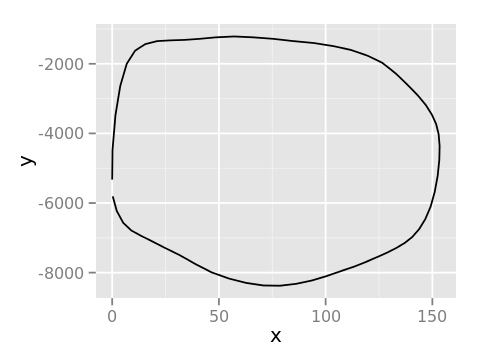

In [143]:

##Let us plot one dynamoter plot and see what it looks like

p <- ggplot(AL, aes(x, y))
#p + geom_point() + geom_path()
p  + geom_path()
options(repr.plot.width=4, repr.plot.height=3)


Good enough for educational purposes. This data was synthesized based on statistics from real dynamometer cards

# What types of data do I have?

In [144]:
# sapply the class function to each column
sapply(mydata, class)

well        date         idx           x           y 
"character" "character"   "integer"   "numeric"   "numeric"

# Questions:

Do these data types look right?  We can already see from the head(mydata) that we have dates, but it is of the class "Factor".  We should convert it to a numeric type, specifically a time type.  Let's not destroy anything so we'll create a new column for the converted data type.  Using a handy function from lubridate...

In [145]:
head(mydata$date)

[1] "8/16/2013 1:55:22 AM" "8/16/2013 1:55:22 AM" "8/16/2013 1:55:22 AM"
[4] "8/16/2013 1:55:22 AM" "8/16/2013 1:55:22 AM" "8/16/2013 1:55:22 AM"

## Data Engineering

Convert string format 'date' to a datetime type

In [146]:
mydata$date_date <- mdy_hms((mydata$date))

In [147]:
head(mydata$date_date)

[1] "2013-08-16 01:55:22 UTC" "2013-08-16 01:55:22 UTC"
[3] "2013-08-16 01:55:22 UTC" "2013-08-16 01:55:22 UTC"
[5] "2013-08-16 01:55:22 UTC" "2013-08-16 01:55:22 UTC"

In [148]:
sapply(mydata, class)

$well
[1] "character"

$date
[1] "character"

$idx
[1] "integer"

$x
[1] "numeric"

$y
[1] "numeric"

$date_date
[1] "POSIXct" "POSIXt"

In [149]:
sapply(mydata, function(x) n_distinct(x))

well      date       idx         x         y date_date 
      263     57853        60   2887143   2887139     57853

## Question: Why bother converting the string to a datetime?

# Descriptive Stats

Pandas gives us some useful methods for summarizing or describing our data.  Try the following

In [150]:
summary(mydata)

     well               date                idx              x         
 Length:3472980     Length:3472980     Min.   : 1.00   Min.   :-35.08  
 Class :character   Class :character   1st Qu.:15.75   1st Qu.: 20.49  
 Mode  :character   Mode  :character   Median :30.50   Median : 76.71  
                                       Mean   :30.50   Mean   : 74.22  
                                       3rd Qu.:45.25   3rd Qu.:120.86  
                                       Max.   :60.00   Max.   :523.21  
       y              date_date                  
 Min.   :-29994.6   Min.   :2013-03-01 21:18:48  
 1st Qu.: -4567.5   1st Qu.:2014-03-24 05:19:13  
 Median : -1715.5   Median :2014-08-31 11:31:58  
 Mean   : -1832.0   Mean   :2014-08-23 23:46:59  
 3rd Qu.:   692.1   3rd Qu.:2015-02-08 03:45:15  
 Max.   : 27836.6   Max.   :2024-10-04 05:16:23  

# Question:

1.  Over what time span does our data exist?
2.  What are typical values of x,y, idx?  
3.  How many unique wells are we talking about?
4.  How many unique dates?
5.  What kinds of data do we have?

Thoughts: Categorical Variables (Nominal Data): Some variables may be better treated as categorical if they don't have numeric properties.  For example, if we were seeing menu items, item 10 is not twice as great as item 5.  If were to treat menu items as numeric variables in a predictive model we could get strange results.  it's a judgement call.  Columns with fewer unique values might be treated as categorical variables and the unique values then become levels.  

Ordinal Data: Columns with fewer unique numeric values may be part of a numeric sequence and we may treat them as ordinals e.g. 1st, 2nd, 3rd...  If this is the case we may choose to reshape our data so that 1st, 2nd, 3rd become their own columns!  Each sample would then have its own set of ordinal positions. 

A classic example are binary values.  If we see two unique values in a columns it very well could be a true/false or yes/no variable.

If we see a variable with one unique value and our dataset will never grow, we can disregard it completely since it doesn't differentiate samples

# Do we have missing values?
Missing values have to be dealt with carefully and are another topic.  Imputation or exclusion are options but this is fuzzy science.  Fortunately for us, we have a complete dataset

In [151]:
print(sapply(mydata, function(x) sum(is.nan(x))))

     well      date       idx         x         y date_date 
        0         0         0         0         0         0 


# What did we learn?

Do we have any categorical, cardinal, ordinal, or ordinal data?

## Let's take a look at the unique values of well and date

In [152]:
unique(mydata$idx)

[1]  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
[26] 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50
[51] 51 52 53 54 55 56 57 58 59 60

In [153]:
unique(mydata$well)

[1] "Alabama"     "Alaska"      "Alvin"       "Arizona"     "Arkansas"   
  [6] "Asia"        "Audi"        "Bagel"       "Balou"       "Barclay"    
 [11] "Barney"      "Beck"        "Bellatrix"   "Bianca"      "Biloxi"     
 [16] "Birdie"      "Biscuit"     "Blanca"      "Bobbafett"   "Bodie"      
 [21] "Bono"        "Booboo"      "Bootsie"     "Bordeaux"    "Brandy"     
 [26] "Bren"        "Bronco"      "Bruin"       "Bubbles"     "Buffy"      
 [31] "Burt"        "Butler"      "Button"      "California"  "Calvin"     
 [36] "Candy"       "Carter"      "Cece"        "Cessa"       "Chandler"   
 [41] "Chaucer"     "Chevy"       "China"       "Choochoo"    "Cisco"      
 [46] "Claire"      "Cleopatra"   "Clooney"     "Coco(nut)"   "Colorado"   
 [51] "Connecticut" "Connor"      "Cosmo"       "Crosby"      "Cupcake"    
 [56] "Daisy"       "Dallas"      "Daphne"      "Delaware"    "Delilah"    
 [61] "Diva"        "Doc"         "Domino"      "Donna"       "Donovan"    
 [66] "Dulus"       "Dutch"       "Ebony"       "Ed"          "Elton"      
 [71] "Elwood"      "Ernie"       "Faith"       "Faya"        "Felix"      
 [76] "Fig"         "Fiona"       "Florida"     "Foxy"        "Fritz"      
 [81] "Fuse"        "Georgia"     "Giblet"      "Gibson"      "Gingi"      
 [86] "Goofy"       "Graysen"     "Greystoke"   "Guinness"    "Hawaii"     
 [91] "Hershey"     "Holly"       "Honey"       "HuckFinn"    "Hudson"     
 [96] "Hutch"       "Idaho"       "Ike"         "Illinois"    "Indiana"    
[101] "Indira"      "Iowa"        "Iris"        "Ivory"       "Jade"       
[106] "Jasmine"     "Jasper"      "Jazzy"       "Jeeves"      "Jenna"      
[111] "Jenne"       "Joy"         "Kai"         "Kalua"       "Kaly"       
[116] "Kansas"      "Kassie"      "Kaya"        "Keanna"      "Keesha"     
[121] "Keiko"       "Kentucky"    "Kiefer"      "Kingston"    "Koby"       
[126] "Kona"        "Laguna"      "Landon"      "Larissa"     "Lefty"      
[131] "Leia"        "Lexi"        "Lilbit"      "Lilypie"     "Linus"      
[136] "Logan"       "Lola"        "Luca"        "Lucy"        "Luke"       
[141] "Madonna"     "Malble"      "Malibu"      "Margo"       "Marshmellow"
[146] "Marti"       "Max"         "Maya"        "Meadow"      "Mercedes"   
[151] "Merlot"      "Merry"       "Mia"         "Midnight"    "Midori"     
[156] "Mika"        "Milan"       "Mira"        "Mischa"      "Mitzi"      
[161] "Moby"        "Mochi"       "Monet"       "Monkey"      "Mooshie"    
[166] "Mozart"      "MrBig"       "Muggles"     "Mulder"      "Mulligan"   
[171] "Murphy"      "Mylo"        "Nanda"       "Nate"        "Nell"       
[176] "Niana"       "Nico"        "Noodle"      "Nugget"      "Olive"      
[181] "Onyx"        "Otis"        "Owen"        "Ozzie"       "Paddington" 
[186] "Paisley"     "Paris"       "Parker"      "Paulie"      "Pazzo"      
[191] "Peanut"      "Pearl"       "Pepper"      "Persia"      "Pesci"      
[196] "Phoenix"     "Picasso"     "Pinot"       "Pipsie"      "Pixie"      
[201] "Porche"      "Quattro"     "Ramona"      "Redford"     "Reece"      
[206] "Rico"        "RobinHood"   "Rocco"       "Rocky"       "Romeo"      
[211] "Roxie"       "Rufus"       "Rusty"       "Scotty"      "Scout"      
[216] "Shadow"      "Shaggy"      "Shane"       "Shaq"        "Sheba"      
[221] "Silas"       "Skip"        "Skitty"      "Skyler"      "Smitty"     
[226] "Snooky"      "Snoopy"      "Sookie"      "Spark"       "Sprite"     
[231] "Stitch"      "Strsky"      "Sugar"       "Summer"      "Sunny"      
[236] "Sushi"       "Sweetpea"    "Syrah"       "Tallulah"    "Tango"      
[241] "Tank"        "Tanner"      "Tatertot"    "Theo"        "Tibbs"      
[246] "Timber"      "Tink"        "Toast"       "Toffee"      "Tonka"      
[251] "Vegas"       "Wednesday"   "Wilbur"      "Willow"      "Winnie"     
[256] "Wolfie"      "Yoshiko"     "Zach"        "Zara"        "Zeke"       
[261] "Zelda"       "Zeppelin"    "ZsaZsa"

# Let's treat well and date as factors and look at load and position

In [154]:
well_dates <- group_by(mydata, well, date_date)

In [155]:
tots <- summarise(well_dates, dist = n_distinct(idx), y=mean(y), x = mean(x))

In [156]:
head(tots)

,well,date_date,dist,y,x
1,Alabama,2013-08-16 01:55:22,60,-4833.331,80.9407
2,Alabama,2013-08-16 23:49:23,60,-4833.331,80.9407
3,Alabama,2013-09-03 00:17:00,60,-4831.002,81.98409
4,Alabama,2013-09-06 09:38:47,60,-4756.602,81.16145
5,Alabama,2013-09-06 16:13:14,60,-4756.602,81.16145
6,Alabama,2013-09-13 03:48:51,60,-4761.007,81.38091


Are the number of unique values in idx not 60?  No.  Then all well-dates have the same index 1:60.  It turns out that each well on a given date has 60 sequential samples (x,y) taken. We will investigate these samples

# Data Types?

In [157]:
print(sapply(mydata, class))

$well
[1] "character"

$date
[1] "character"

$idx
[1] "integer"

$x
[1] "numeric"

$y
[1] "numeric"

$date_date
[1] "POSIXct" "POSIXt" 



## SQL-like operation.  Using dplyr

Show all records for well "Alabama" in 2015

Dplyr aims to provide a function for each basic verb of data manipulation:

filter() (and slice())  
arrange()  
select() (and rename())  
distinct()  
mutate() (and transmute())  
summarise()  
sample_n() (and sample_frac())  
If youâve used plyr before, many of these will be familar.  

In [158]:
A <- filter(mydata, well == 'Alabama' , year(date_date) == 2015)
A$date_date<-as.character(A$date_date)

In [159]:
slice(A, 5:10)

,well,date,idx,x,y,date_date
1,Alabama,1/2/2015 11:21:55 AM,5,3.75983,2137.927,2015-01-02 11:21:55
2,Alabama,1/2/2015 11:21:55 AM,6,5.491333,2722.558,2015-01-02 11:21:55
3,Alabama,1/2/2015 11:21:55 AM,7,7.443874,3202.173,2015-01-02 11:21:55
4,Alabama,1/2/2015 11:21:55 AM,8,9.717677,3567.49,2015-01-02 11:21:55
5,Alabama,1/2/2015 11:21:55 AM,9,12.43039,3854.281,2015-01-02 11:21:55
6,Alabama,1/2/2015 11:21:55 AM,10,15.79238,4120.73,2015-01-02 11:21:55


# Summarize the data

In [160]:
well_summary = summary(mydata)
well_summary

     well               date                idx              x         
 Length:3472980     Length:3472980     Min.   : 1.00   Min.   :-35.08  
 Class :character   Class :character   1st Qu.:15.75   1st Qu.: 20.49  
 Mode  :character   Mode  :character   Median :30.50   Median : 76.71  
                                       Mean   :30.50   Mean   : 74.22  
                                       3rd Qu.:45.25   3rd Qu.:120.86  
                                       Max.   :60.00   Max.   :523.21  
       y              date_date                  
 Min.   :-29994.6   Min.   :2013-03-01 21:18:48  
 1st Qu.: -4567.5   1st Qu.:2014-03-24 05:19:13  
 Median : -1715.5   Median :2014-08-31 11:31:58  
 Mean   : -1832.0   Mean   :2014-08-23 23:46:59  
 3rd Qu.:   692.1   3rd Qu.:2015-02-08 03:45:15  
 Max.   : 27836.6   Max.   :2024-10-04 05:16:23  

# Distribution of the Population

We can use a histogram to display the relative likelihood of seeing a well experience a certain load.  Notice that the most likely values for load are centered around the mean and the less likely values are spread out away from the mean.  We can also fit a function (kernel density) to approximate this histogram with a function.  or to make life easy, we could assume the density function to be constrained by a set of parameters.  E.g. The distribution is probably Gaussian and we then just need to know about the mean and variance of the distribution to describe it.

Why do we care?  We can use the distribution to predict the likelihood of finding a value or range of values.  See the graph below.  The histogram is of Oil Well Loads, the red line is a kernel density estimate (a non-parametric function that describes approximates the distribution), and the blue line is the normal fit.  The normal fit is pretty close!  Maybe we assume that in a perfect world where we had EVERY sample, the distribution would BE normal.  This is our assumption.

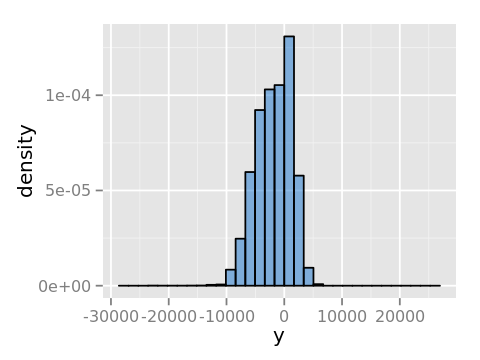

In [161]:
p <- ggplot(tots, aes(x=y))

p  + geom_histogram(aes(y = ..density..), fill='dodgerblue3', color = 'black', alpha = .5)  
#    geom_density(color='red', bw=1000) +
#    stat_function(fun=dnorm, args=list(mean=mean(tots$y), sd=sd(tots$y)), colour='blue') 


This distribution looks 'normal' or 'gaussian.  Let's plot the normal probability distribution along with the frequency of loads

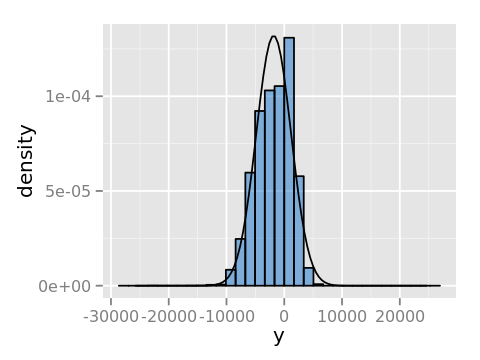

In [162]:
p <- ggplot(tots, aes(x=y))

p  + geom_histogram(aes(y = ..density..), fill='dodgerblue3', color = 'black', alpha = .5)  +
#    geom_density(color='red', bw=1000) +
    stat_function(fun=dnorm, args=list(mean=mean(tots$y), sd=sd(tots$y)), colour='black') 

## Assuming Gaussian Distribution

We can estimate the probability of finding a well with a mean load in a given range.  For example, the probability of finding a well whose mean load is greater than zero is given by:

In [163]:
mean = mean(tots$y)
sd = sd(tots$y)

In [164]:
print(mean)
print(sd)

[1] -1832.019
[1] 3021.86


## One sample z-test
<img src = 'https://wikimedia.org/api/rest_v1/media/math/render/svg/3001169229a7ea675bf160036217bbb4572ef07d' align = left>  

We can reformulate the question as "How many standard deviations is a well's load away from the population mean?"

The probability of finding a well whose load is z standard deviations away is the area under the upper tail of the normal pdf.  This is integral is the cdf (cumulative distribution function).  In R, this is easy to compute

https://stat.ethz.ch/R-manual/R-devel/library/stats/html/Normal.html

In [165]:
# Assuming a normal distribution, what is the probability that a well will have a mean load of 0 or more
pnorm(0, mean = mean(tots$y), sd = sd(tots$y), lower.tail = FALSE, log = FALSE)

[1] 0.2721726

### or

In [166]:
z = (mean - 0)/sd
pnorm(z)

[1] 0.2721726

# Towards Hypothesis Testing
Let's say we want to calculate the mean well load, but we can't afford to sample every well so we sample a few and average.  We might expect that if we repeated this experiment, sometimes we would be a little high and sometimes a little low.  On average (average of average, I know it gets confusing) would be the population mean.  Our high averages would balance our low averages.  

We might also suspect that, the more samples we have, the closer are estimate would be to the actual population mean.  Let's do an experiment where we randomly sample the wells with different sample sizes and then plot the distribution of means.

## Try different sample sizes 'size' and see how the samples get closer to the population mean

# Sample Size and Estimates of the Mean
What if we don't have the entire population, but just a sample?  Even here we haven't sampled every well at every moment, so this is just a sample of the truth.  Assuming it is real.  How confident are we that we have a good estimate of the population mean?  Seems reasonable that the more samples we have the better our estimate.

In [167]:
#Function that generates set of 1000 sample means, where the sample size can be changed

samp <- function(size = 500, tots = data.frame())
    {
    sample_means <- list()
    idx <- list()
    for (n in 1:1000)
        {
        sample_means[n] <- mean(sample(tots$y, size=size, replace = FALSE, prob = NULL))
        }
    sample_means <- data.frame(sample_means)
    sample_means <- t(sample_means)
    colnames(sample_means) <- 'y'
    data.frame(sample_means)
    
    }

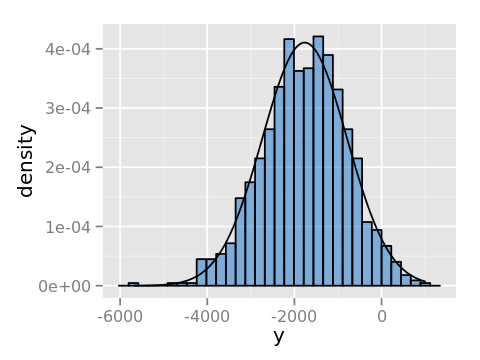

In [168]:
#n is the number of samples used to estimage the mean.  Change its value and observe the plot
n = 10

y_samp = samp(n,tots)
p <- ggplot(y_samp, aes(x=y))

p  + geom_histogram(aes(y = ..density..), fill='dodgerblue3', color = 'black', alpha = .5)  +
#    geom_density(color='red', bw=1000) +
    stat_function(fun=dnorm, args=list(mean=mean(y_samp$y), sd=sd(y_samp$y)), colour='black') 

##Question:  What does increasing or decreasing sample size do?

Using the one sided z test formula we can calculate the probability of a sample mean being different than the population mean.  We know from above the population mean and std are:

In [169]:
n = 500
z = (mean - 0)/sd*(sqrt(n))
pnorm(z)

[1] 3.636521e-42

#This is astronomically low p!  
So if we were to find 500 wells with a mean of zero from this population we would likely say these wells don't belong to this distribution.  If our null hypothesis was "nothing fishy here, these wells are just like all the others" we would reject the null hypothesis in favor of the alternative.  Usually the cutoff is = = .05 for a one-sided hypothesis test

## A closer look at Alabama and Dutch

In [170]:
Dutch = filter(tots, well == 'Dutch')
n = dim(Dutch)[1]
mu = mean(Dutch$y)

In [171]:
z = (mean - mu)/sd*(sqrt(n))

In [172]:
pnorm(z)

[1] 0.1582343

## Question: What do we know about Dutch compared to the rest of the wells?

# Box Plot
The "dots" at the end of the boxplot represent outliers. There are a number of different rules for determining if a point is an outlier, but the method that R and ggplot use is the "1.5 rule". If a data point is:

less than Q1 - 1.5*IQR
greater than Q3 + 1.5*IQR
then that point is classed as an "outlier". The line goes to the first data point before the "1.5" cut-off. Note: IQR = Q3 - Q1



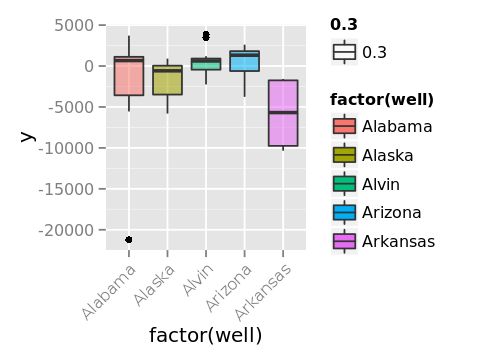

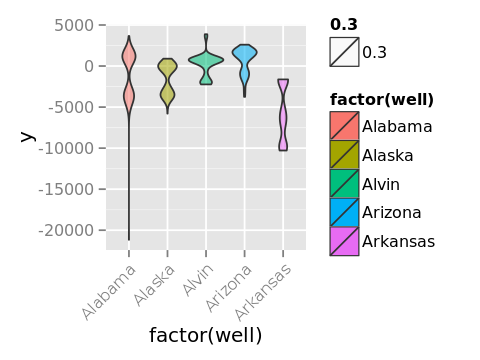

In [173]:
p <- ggplot(head(tots, 1000), aes(factor(well), y, fill=factor(well), alpha = .3))

p + geom_boxplot() +

theme(axis.text.x = element_text(angle = 45, hjust = 1))

q <- ggplot(head(tots, 1000), aes(factor(well), y, fill=factor(well), alpha = .3))

q + geom_violin() +

theme(axis.text.x = element_text(angle = 45, hjust = 1))

In [174]:
head(tots)

,well,date_date,dist,y,x
1,Alabama,2013-08-16 01:55:22,60,-4833.331,80.9407
2,Alabama,2013-08-16 23:49:23,60,-4833.331,80.9407
3,Alabama,2013-09-03 00:17:00,60,-4831.002,81.98409
4,Alabama,2013-09-06 09:38:47,60,-4756.602,81.16145
5,Alabama,2013-09-06 16:13:14,60,-4756.602,81.16145
6,Alabama,2013-09-13 03:48:51,60,-4761.007,81.38091


In [175]:
class(tots$date)

[1] "POSIXct" "POSIXt"

In [176]:
# Fit regression model (using the natural log of one of the regressors)
# How does mean load change over time
#We'll look at one well.  You can try different wells

In [177]:
model <- lm(y ~ date_date, tots, tots$well == 'Alabama')

In [178]:
summary(model)


Call:
lm(formula = y ~ date_date, data = tots, subset = tots$well == 
    "Alabama")

Residuals:
     Min       1Q   Median       3Q      Max 
-17439.2   -853.5    -14.9   1024.4   5073.8 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -2.780e+05  1.545e+04  -18.00   <2e-16 ***
date_date    1.961e-04  1.094e-05   17.92   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 1800 on 203 degrees of freedom
Multiple R-squared:  0.6128,	Adjusted R-squared:  0.6109 
F-statistic: 321.3 on 1 and 203 DF,  p-value: < 2.2e-16


# What do these values mean?
 
R-squared?  
Coefficients?  
Residuals?

https://stat.ethz.ch/R-manual/R-devel/library/stats/html/lm.html
https://stat.ethz.ch/R-manual/R-devel/library/stats/html/summary.lm.html

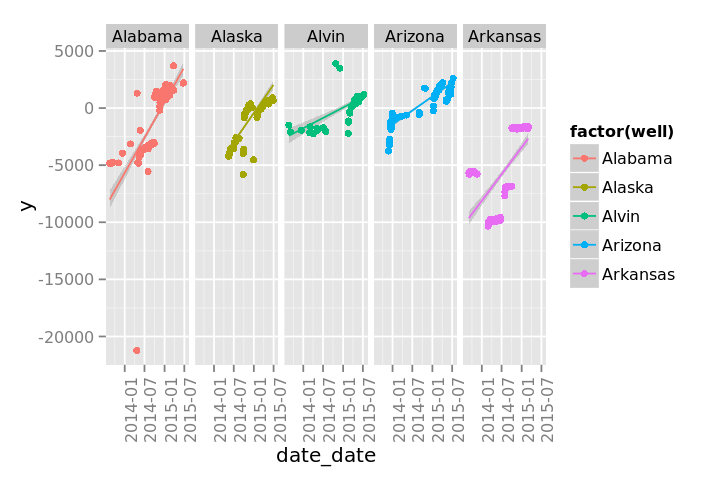

In [179]:
# Separate regressions of load vs time
c <- ggplot(head(tots, 1000), aes(y=y, x=date_date, colour=factor(well)))
c + theme(axis.text.x = element_text(angle = 90, hjust = 1)) + 
    stat_smooth(method=lm) + 
    geom_point() + 
    facet_grid(. ~ well)
options(repr.plot.width=6, repr.plot.height=4)

What's happening to the average well load over time?  Any idea why?  Need more data?  We fit a straight line.  Is this a good approximation?  We should like at the "residuals"  the difference between the actual point and the fit to see.

In [180]:
#Overall

model <- lm(y ~ date_date, tots)

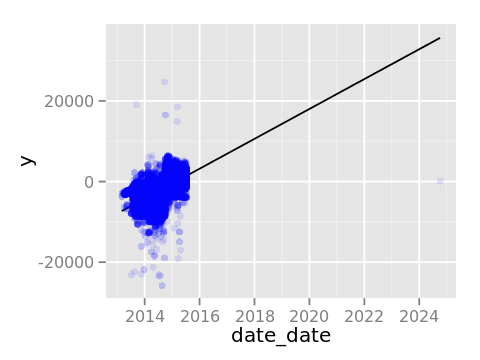

In [181]:
# Separate regressions of load vs time
c <- ggplot(tots, aes(y=y, x=date_date)) + 
    stat_smooth(method=lm, color = 'black') +
    geom_point(color  = 'blue', alpha = .1)
c
options(repr.plot.width=4, repr.plot.height=3)

In [182]:
head(tots)

,well,date_date,dist,y,x
1,Alabama,2013-08-16 01:55:22,60,-4833.331,80.9407
2,Alabama,2013-08-16 23:49:23,60,-4833.331,80.9407
3,Alabama,2013-09-03 00:17:00,60,-4831.002,81.98409
4,Alabama,2013-09-06 09:38:47,60,-4756.602,81.16145
5,Alabama,2013-09-06 16:13:14,60,-4756.602,81.16145
6,Alabama,2013-09-13 03:48:51,60,-4761.007,81.38091


In [183]:
#lets remove that weird date
tots$date_date<-as.character(tots$date_date)
tots <- filter(tots, well == 'Alabama' , year(date_date) < 2017)
tots$date_date <- ymd_hms((tots$date))

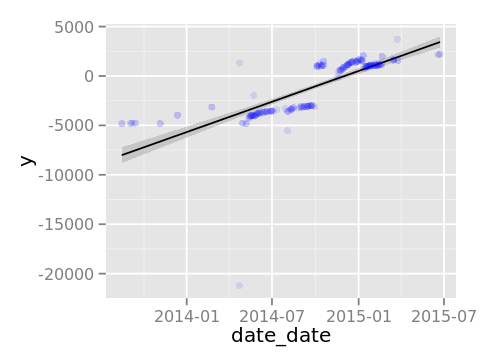

In [184]:
# Separate regressions of load vs time
c <- ggplot(tots, aes(y=y, x=date_date)) + 
    stat_smooth(method=lm, color = 'black') +
    geom_point(color  = 'blue', alpha = .1)
c
options(repr.plot.width=4, repr.plot.height=3)

In [185]:
#Overall

model <- lm(y ~ date_date, tots)
tots$res <- resid(model)

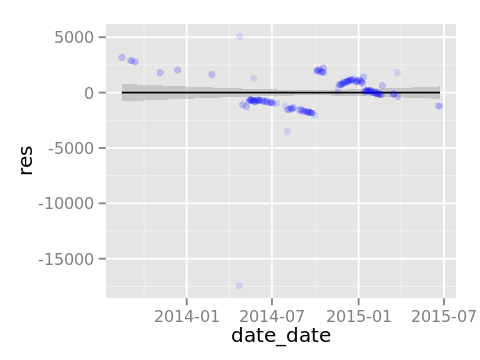

In [186]:
c <- ggplot(tots, aes(y=res, x=date_date)) + 
    stat_smooth(method=lm, color = 'black') +
    geom_point(color  = 'blue', alpha = .1)
c

Notice the spread is uniform. Not heterskedastic
http://www.statsmakemecry.com/smmctheblog/confusing-stats-terms-explained-heteroscedasticity-heteroske.html

<img src="http://www.sageoiltools.com/products/Dyno%20Card%20Shapes%202011%20small.jpg">

In [187]:
dynamo = filter(mydata, well == 'Alabama')

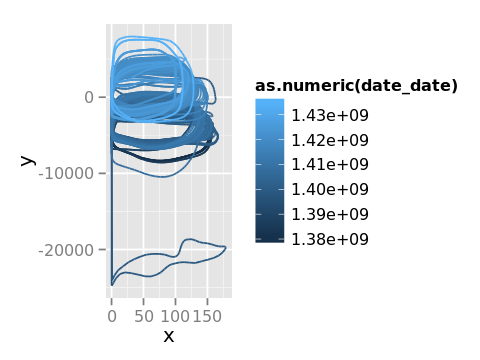

In [188]:
p <- ggplot(dynamo, aes(x, y, colour = as.numeric(date_date)))
#p + geom_point() + geom_path()
p  + geom_path()
options(repr.plot.width=4, repr.plot.height=3)

# Discussion: 
What can we say about these plots?  One of these things is not like the other...

# Dimensionality Reduction

Each well on each date has 60 sample points taken in order.  Each point has an x and y dimension.  If we want to compare well performance we can aggregate the data as we did in the previous examples and compare the mean loads of wells on different days, but what if we wanted to say more?  We know that engineers determine the health of a well based on the SHAPE of the plot.  How can we compare, quantitatively the shapes of these plots to one another?

We know all of these plots follow a similar pattern.  They move around in a cycle.  Each sample is successive in time, so there is a first, second... 60th sample for each well on each date.  What if we compared each well's nth sample to each other?  How should we transform the data to do this?

# Data Transformation: Pivot

In [189]:
mydata <- select(mydata, -c(date_date))

In [190]:
mydatax <- select(mydata, -c(y))
mydatay <- select(mydata, -c(x))

In [191]:
mydatax_cast = dcast(mydatax, well + date~idx)
mydatay_cast = dcast(mydatay, well + date~idx)

Using x as value column: use value.var to override.
Using y as value column: use value.var to override.


In [192]:
mydatax_cast <- select(mydatax_cast, -c(well, date))
mydatay_cast <- select(mydatay_cast, -c(well, date))

In [193]:
mydata_cast <- cbind(mydatax_cast, mydatay_cast)

In [194]:
dim(mydata_cast)

[1] 57883   120

In [195]:
#we have pivoted the data.  Now the 60 indexes per well per date appear as columns.  There are 60 
#coluns for x and 60 for y.

In [196]:
head(mydata_cast)

,1,2,3,4,5,6,7,8,9,10,â¯,51,52,53,54,55,56,57,58,59,60
1,0.02354585,0.1210251,0.951139,2.23922,3.785148,5.529454,7.453081,9.659752,12.25074,15.44234,,-995.3561,-1142.878,-1216.786,-1201.822,-1172.001,-1143.322,-1105.207,-1100.407,-1081.828,-982.6641
2,0.02354585,0.1210251,0.951139,2.23922,3.785148,5.529454,7.453081,9.659752,12.25074,15.44234,,-995.3561,-1142.878,-1216.786,-1201.822,-1172.001,-1143.322,-1105.207,-1100.407,-1081.828,-982.6641
3,0.009179709,0.1236786,1.149555,2.829941,5.043753,7.783505,11.043,14.86048,19.26573,24.38846,,-1905.319,-1934.07,-1894.069,-1805.135,-1709.286,-1623.399,-1530.822,-1432.112,-1273.135,-1033.988
4,0.004491059,0.1127584,1.112254,2.714002,4.79791,7.356587,10.40478,13.99296,18.17859,23.10785,,-2175.561,-2154.406,-2067.658,-1938.521,-1806.45,-1680.53,-1543.812,-1391.466,-1159.582,-840.5666
5,0.01002852,0.1184961,1.09446,2.655841,4.664143,7.102145,9.971961,13.32869,17.22705,21.81806,,-2044.721,-2066.896,-2022.889,-1927.191,-1825.828,-1730.628,-1626.529,-1518.903,-1350.286,-1097.75
6,0.0103553,0.1210533,1.112495,2.717068,4.801739,7.351422,10.36266,13.88566,17.96629,22.7499,,-1864.785,-1899.275,-1865.359,-1778.371,-1684.318,-1598.058,-1503.877,-1407.258,-1253.006,-1016.965


# Do we really need this many points?

Dynameter plots are, for the most parts parallelograms 

<img src = 'https://upload.wikimedia.org/wikipedia/commons/thumb/4/41/Parallelogram.svg/255px-Parallelogram.svg.png' align = left>


If you had a bunch of parallelograms, and they all started at the same position 'D'.  How much data do we really need to describe how different they are?  Do we need all 60 points?  Do we need 20?  Intuitively how many points do you think we need?

# Principal Component Analysis (PSA)

"Principal component analysis (PCA) is a statistical procedure that uses an orthogonal transformation to convert a set of observations of possibly correlated variables into a set of values of linearly uncorrelated variables called principal components. The number of principal components is less than or equal to the number of original variables"

In our case we have a set of columns.  Each column is the nth point in our dynamometer plot.  There is an x column and y column for each nth point for a total of 120 columns.  

https://en.wikipedia.org/wiki/Principal_component_analysis

## Q: Variables are scaled and centered.  Why is this important?
## A: We care about shape.  

In [197]:
pca <- prcomp(mydata_cast, scale = T)

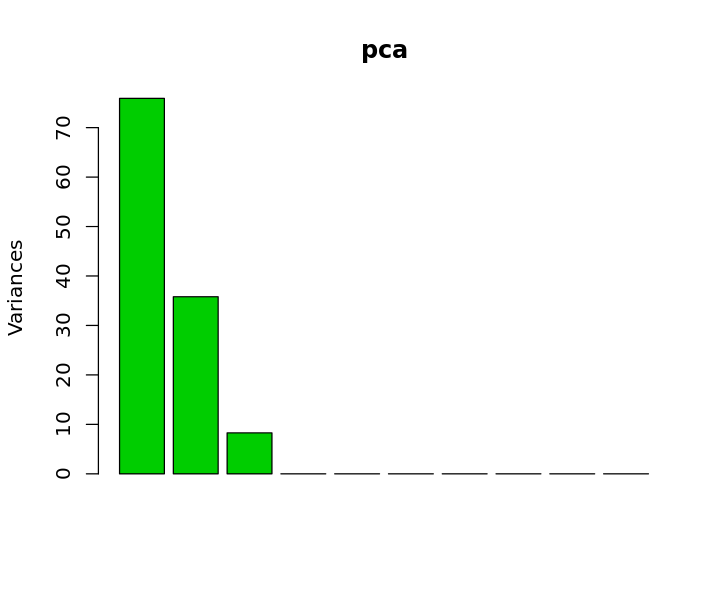

In [198]:
screeplot(pca, type = c("barplot"), col=3)
options(repr.plot.width=6, repr.plot.height=5)

In [199]:
X <- pca$x

In [200]:
X3 <- X[,1:3]

In [201]:
head(X3)

PC1,PC2,PC3
-12.620750,-1.084255,2.757364
-12.620750,-1.084255,2.757364
-7.224490,1.786781,1.121181
-7.3897474,1.7104495,-0.1450255
-8.0933934,0.8482018,0.7530566
-8.007414,1.279935,1.076088


In [202]:
X3 <- cbind(select(dcast(mydatax, well + date~idx), c(well,date)), X3)

Using x as value column: use value.var to override.


In [203]:
head(X3)

,well,date,PC1,PC2,PC3
1,Alabama,1/11/2015 12:34:29 AM,-12.62075,-1.084255,2.757364
2,Alabama,1/11/2015 2:35:55 AM,-12.62075,-1.084255,2.757364
3,Alabama,1/13/2015 2:17:14 AM,-7.22449,1.786781,1.121181
4,Alabama,1/14/2015 9:37:26 AM,-7.389747,1.710449,-0.1450255
5,Alabama,1/15/2015 2:36:42 PM,-8.093393,0.8482018,0.7530566
6,Alabama,1/16/2015 12:36:06 PM,-8.007414,1.279935,1.076088


In [204]:
dynamopca <- filter(X3, well == 'Alabama')

## Experiment with different parameters in the graph

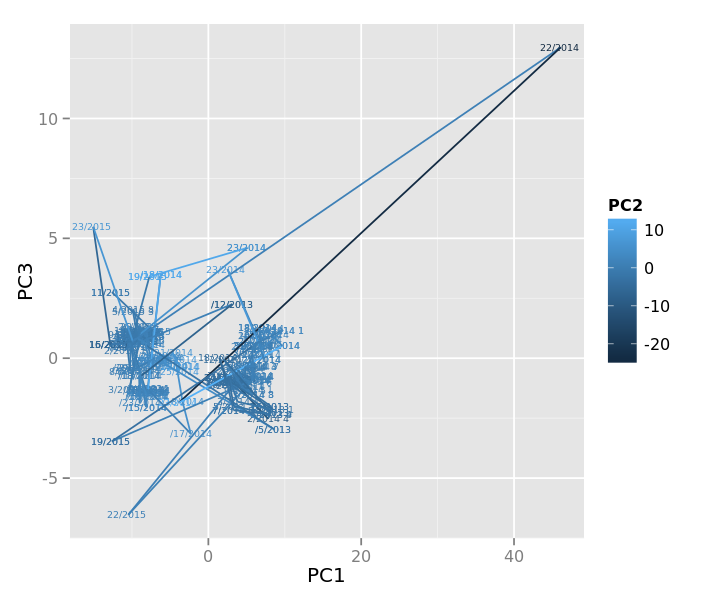

In [205]:
p <- ggplot(dynamopca, aes(PC1, PC3, colour = PC2, label = substr(dynamopca$date, start=3, stop=10)))
#p + geom_point() + geom_path()
p    + geom_text(check_overlap = FALSE, size = 2) + geom_path()

In the reduced data set, the outlier dynamometer plot appears as a point away from the main cluster.  In this reduced dimensional space we can easily spot the bad wells or find groupings of similar wells.  This is also true for ML.  Our models will train faster and in some cases be more accurate (although this isn't categorically true) by operating in this abridged vector space.  As an exercise, you might try adding date labels to the plot.  But we can find that outlier and see what its dynamomoter plot looks like

In [206]:
clusters <- select(clusters, c(well, date, PC1, PC2, PC3, Assignments))

In [208]:
clusters$date <- mdy_hms(clusters$date)

In [209]:
mydata$date <- mdy_hms(mydata$date)

In [210]:
head(mydata)
head(clusters)

,well,date,idx,x,y
1,Alabama,2013-08-16 01:55:22,1,0.0007400195,-5327.237
2,Alabama,2013-08-16 01:55:22,2,0.1559583,-4476.758
3,Alabama,2013-08-16 01:55:22,3,1.536036,-3475.778
4,Alabama,2013-08-16 01:55:22,4,3.779102,-2636.549
5,Alabama,2013-08-16 01:55:22,5,6.817062,-1999.546
6,Alabama,2013-08-16 01:55:22,6,10.73117,-1622.669


,well,date,PC1,PC2,PC3,Assignments
1,Alabama,2013-08-16 01:55:22,-8.243341,2.918071,2.023029,35
2,Alabama,2013-08-16 23:49:23,-8.243341,2.918071,2.023029,35
3,Alabama,2013-09-03 00:17:00,-8.495328,2.311737,2.154067,35
4,Alabama,2013-09-06 09:38:47,-8.148383,2.731808,2.341957,35
5,Alabama,2013-09-06 16:13:14,-8.148383,2.731808,2.341957,35
6,Alabama,2013-09-13 03:48:51,-8.206878,2.583768,2.282913,35


In [211]:
output <- merge(mydata, clusters, by = c("well","date"))

In [212]:
head(output)

,well,date,idx,x,y,PC1,PC2,PC3,Assignments
1,Alabama,2013-08-16 01:55:22,1,0.0007400195,-5327.237,-8.243341,2.918071,2.023029,35
2,Alabama,2013-08-16 01:55:22,2,0.1559583,-4476.758,-8.243341,2.918071,2.023029,35
3,Alabama,2013-08-16 01:55:22,3,1.536036,-3475.778,-8.243341,2.918071,2.023029,35
4,Alabama,2013-08-16 01:55:22,4,3.779102,-2636.549,-8.243341,2.918071,2.023029,35
5,Alabama,2013-08-16 01:55:22,5,6.817062,-1999.546,-8.243341,2.918071,2.023029,35
6,Alabama,2013-08-16 01:55:22,6,10.73117,-1622.669,-8.243341,2.918071,2.023029,35


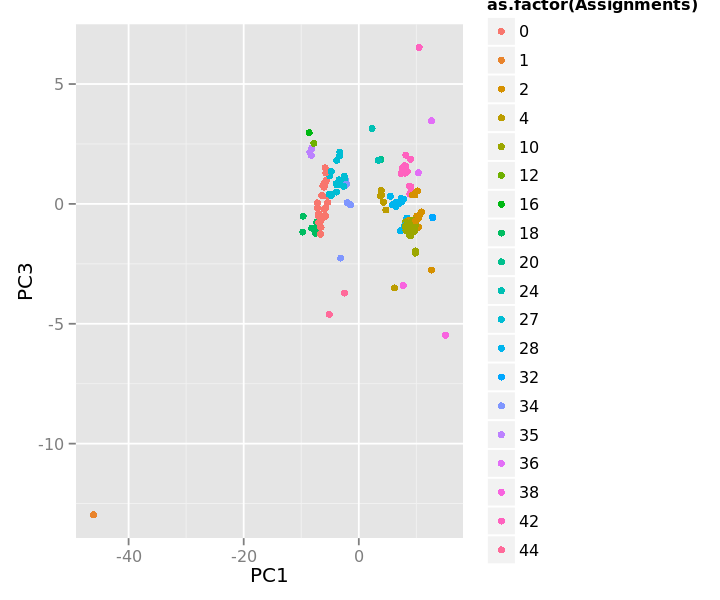

In [213]:
dynamopca <- filter(output, well == 'Alabama')
p <- ggplot(dynamopca, aes(PC1, PC3, colour = as.factor(Assignments)))
#p + geom_point() + geom_path()
p    + geom_point() 

In [214]:
bad_wells <- filter(output, Assignments == 1)

In [215]:
head(bad_wells)

,well,date,idx,x,y,PC1,PC2,PC3,Assignments
1,Alabama,2014-04-22 13:37:34,1,0.0880833,-24655.01,-46.1127,24.11978,-12.96721,1
2,Alabama,2014-04-22 13:37:34,2,0.4305763,-24753.07,-46.1127,24.11978,-12.96721,1
3,Alabama,2014-04-22 13:37:34,3,2.85975,-24366.09,-46.1127,24.11978,-12.96721,1
4,Alabama,2014-04-22 13:37:34,4,7.158982,-23754.25,-46.1127,24.11978,-12.96721,1
5,Alabama,2014-04-22 13:37:34,5,13.20662,-23218.65,-46.1127,24.11978,-12.96721,1
6,Alabama,2014-04-22 13:37:34,6,21.22936,-23003.55,-46.1127,24.11978,-12.96721,1


In [216]:
dim(bad_wells)[1]/dim(output)[1]*100


[1] 0.01900385

<img src="http://www.sageoiltools.com/products/Dyno%20Card%20Shapes%202011%20small.jpg">

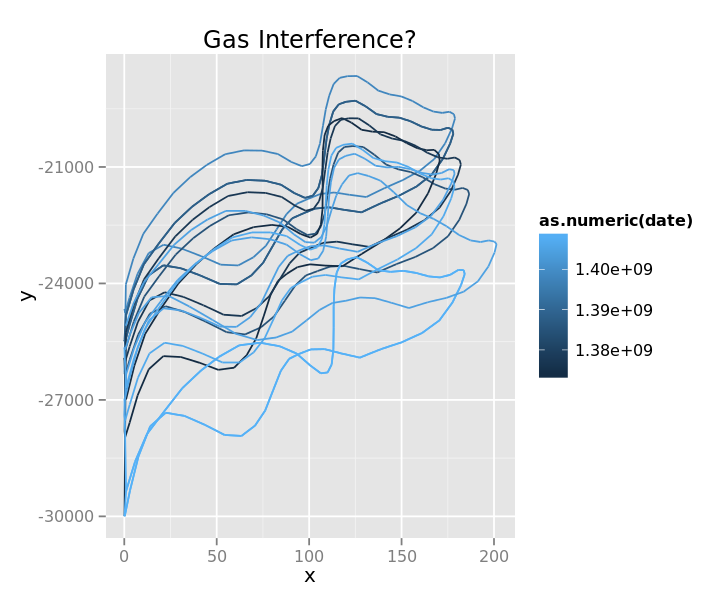

In [217]:
p <- ggplot(head(bad_wells, 60*100), aes(x, y, colour = as.numeric(date)))
#p + geom_point() + geom_path()
p  + geom_path() + ggtitle("Gas Interference?")

## Try seeing what the different shapes look like

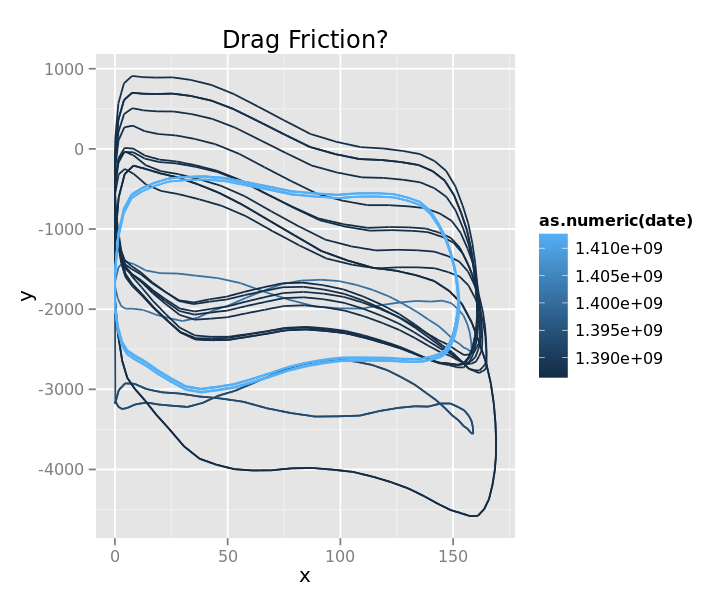

In [218]:
good_wells <- filter(output, Assignments == 44)
p <- ggplot(head(good_wells, 60*20), aes(x, y, colour = as.numeric(date)))
#p + geom_point() + geom_path()
p  + geom_path() + ggtitle("Drag Friction?")

In [219]:
head(output)

,well,date,idx,x,y,PC1,PC2,PC3,Assignments
1,Alabama,2013-08-16 01:55:22,1,0.0007400195,-5327.237,-8.243341,2.918071,2.023029,35
2,Alabama,2013-08-16 01:55:22,2,0.1559583,-4476.758,-8.243341,2.918071,2.023029,35
3,Alabama,2013-08-16 01:55:22,3,1.536036,-3475.778,-8.243341,2.918071,2.023029,35
4,Alabama,2013-08-16 01:55:22,4,3.779102,-2636.549,-8.243341,2.918071,2.023029,35
5,Alabama,2013-08-16 01:55:22,5,6.817062,-1999.546,-8.243341,2.918071,2.023029,35
6,Alabama,2013-08-16 01:55:22,6,10.73117,-1622.669,-8.243341,2.918071,2.023029,35


## Calculate Distance to next failure

* Find wells that have experienced a failure
* For each well calculate distance to failure

In [220]:
Fails <- unique(filter(clusters, Assignments == 44)$well)

In [221]:
Fails

[1] "Alabama"     "Arizona"     "Arkansas"    "Bagel"       "Balou"      
  [6] "Barclay"     "Barney"      "Beck"        "Bellatrix"   "Bianca"     
 [11] "Birdie"      "Blanca"      "Bobbafett"   "Bono"        "Bootsie"    
 [16] "Bordeaux"    "Bren"        "Bubbles"     "California"  "Calvin"     
 [21] "Cece"        "Cessa"       "Chandler"    "Chevy"       "China"      
 [26] "Cisco"       "Colorado"    "Connecticut" "Crosby"      "Cupcake"    
 [31] "Delilah"     "Doc"         "Dulus"       "Ebony"       "Elton"      
 [36] "Ernie"       "Faya"        "Fig"         "Fiona"       "Florida"    
 [41] "Georgia"     "Gingi"       "Goofy"       "Graysen"     "Hershey"    
 [46] "Holly"       "HuckFinn"    "Hudson"      "Hutch"       "Ike"        
 [51] "Illinois"    "Indiana"     "Jade"        "Jasmine"     "Jazzy"      
 [56] "Jeeves"      "Jenna"       "Jenne"       "Kai"         "Kaly"       
 [61] "Kaya"        "Keesha"      "Kentucky"    "Kingston"    "Koby"       
 [66] "Lefty"       "Leia"        "Lexi"        "Lilbit"      "Linus"      
 [71] "Malibu"      "Marti"       "Mercedes"    "Midori"      "Mika"       
 [76] "Milan"       "Mischa"      "Mochi"       "Mooshie"     "Mozart"     
 [81] "MrBig"       "Muggles"     "Murphy"      "Mylo"        "Nanda"      
 [86] "Nell"        "Niana"       "Noodle"      "Nugget"      "Otis"       
 [91] "Paddington"  "Paisley"     "Paulie"      "Pazzo"       "Pepper"     
 [96] "Persia"      "Pesci"       "Picasso"     "Pipsie"      "Pixie"      
[101] "Porche"      "Quattro"     "Rico"        "RobinHood"   "Rocco"      
[106] "Romeo"       "Rufus"       "Scout"       "Shaggy"      "Skitty"     
[111] "Snooky"      "Sookie"      "Strsky"      "Sweetpea"    "Syrah"      
[116] "Tallulah"    "Tango"       "Tank"        "Tanner"      "Tatertot"   
[121] "Theo"        "Tink"        "Toast"       "Toffee"      "Vegas"      
[126] "Wolfie"      "Yoshiko"     "Zach"        "Zeke"

In [222]:
MyRUL <- head(clusters,0)

In [223]:
for (i in Fails){
    tmp <- filter(clusters, well == i)
    x <- filter(tmp, Assignments == 44)$date[1] - filter(tmp)$date
    tmp$RUL <- x
    #print(names(RUL))
    MyRUL <- rbind(MyRUL, tmp)
}

In [224]:
MyRUL <- filter(MyRUL, RUL > 0)

In [225]:
head(MyRUL)

,well,date,PC1,PC2,PC3,Assignments,RUL
1,Alabama,2013-08-16 01:55:22,-8.243341,2.918071,2.023029,35,16501180 secs
2,Alabama,2013-08-16 23:49:23,-8.243341,2.918071,2.023029,35,16422339 secs
3,Alabama,2013-09-03 00:17:00,-8.495328,2.311737,2.154067,35,14951882 secs
4,Alabama,2013-09-06 09:38:47,-8.148383,2.731808,2.341957,35,14658975 secs
5,Alabama,2013-09-06 16:13:14,-8.148383,2.731808,2.341957,35,14635308 secs
6,Alabama,2013-09-13 03:48:51,-8.206878,2.583768,2.282913,35,14075171 secs


In [226]:
dim(MyRUL)

[1] 9807    7

In [232]:
MyRUL$RUL <- as.numeric(MyRUL$RUL)
sapply(MyRUL,class)
head(MyRUL)

$well
[1] "character"

$date
[1] "POSIXct" "POSIXt" 

$PC1
[1] "numeric"

$PC2
[1] "numeric"

$PC3
[1] "numeric"

$Assignments
[1] "integer"

$RUL
[1] "numeric"

,well,date,PC1,PC2,PC3,Assignments,RUL
1,Alabama,2013-08-16 01:55:22,-8.243341,2.918071,2.023029,35,16501180
2,Alabama,2013-08-16 23:49:23,-8.243341,2.918071,2.023029,35,16422339
3,Alabama,2013-09-03 00:17:00,-8.495328,2.311737,2.154067,35,14951882
4,Alabama,2013-09-06 09:38:47,-8.148383,2.731808,2.341957,35,14658975
5,Alabama,2013-09-06 16:13:14,-8.148383,2.731808,2.341957,35,14635308
6,Alabama,2013-09-13 03:48:51,-8.206878,2.583768,2.282913,35,14075171


## Counts Tend to follow a Poisson Distribution
Another way of looking at this is to say, "how many wells will fail in the next n days?"  
https://en.wikipedia.org/wiki/Poisson_distribution

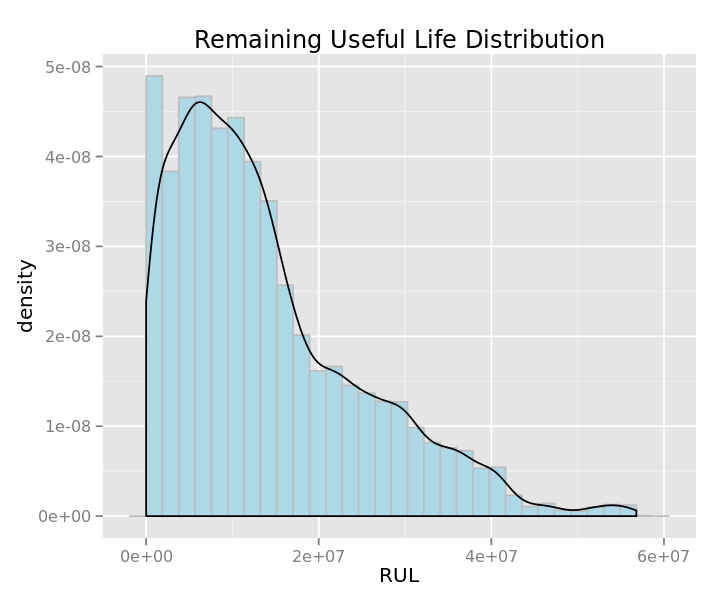

In [249]:
p <- ggplot(MyRUL, aes(x=RUL,  bins = 500))

p  + geom_histogram(aes(y = ..density..), fill="light blue", col = "grey") + 
        geom_density() +  
        ggtitle('Remaining Useful Life Distribution')